# ML HW2 sample code
TODO:
 - Design your CNN model (you are welcomed to use existing models)
 - Hyperparameter tuning
 - Confusion matrix

Report:
 - Structure of CNN model
 - Data Augmentation
 - Draw the confusion matrix

#### Download data


In [55]:
# !gdown 19oEShkdcBJf41nu46anyvu7BgXUffIGi
# !unzip -q 'HW2.zip'

#### Import packages

In [56]:
import os
import random
import csv
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm

#### Hyperparameters and setting

In [57]:
# TODO: modify the hyperparameters
config = Namespace(
    random_seed = 42,
    BATCH = 128,
    n_epoch = 30,
    lr = 1e-4,
    weight_decay = 1e-1,
    ckpt_path = 'model.pth',
)

In [58]:
# DATA_PREFIX = './'
DATA_PREFIX = '/docker_data/ysyang/ml/'
TRA_PATH = DATA_PREFIX + 'data/train/'
TST_PATH = DATA_PREFIX + 'data/test/'
LABEL_PATH = DATA_PREFIX + 'data/train.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)
random.seed(config.random_seed)
np.random.seed(config.random_seed)

Device: cuda


#### Dataset and Dataloader

In [59]:
class FaceExpressionDataset(Dataset):
    def __init__(self, img_path, label_path=None, tfm=T.ToTensor()):
        n_samples = len(os.listdir(img_path))
        if label_path is not None:
            self.images = [f'{img_path}/{i+7000}.jpg' for i in range(n_samples)]
            self.labels = pd.read_csv(label_path)['label'].values.tolist()
        else:
            self.images = [f'{img_path}/{i}.jpg' for i in range(n_samples)]
            self.labels = None
        self.tfm = tfm

    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.tfm(img)
        if self.labels is not None:
            lab = torch.tensor(self.labels[idx]).long()
            return img, lab
        else:
            return img

    def __len__(self):
        return len(self.images)

In [60]:
# # TODO: define your augmentation for training and evaluation
# train_tfm = T.Compose([
#     # ...
#     T.RandomHorizontalFlip(0.5),
#     T.RandomRotation(10),
#     T.ColorJitter(brightness=0.3),
#     T.GaussianBlur(kernel_size=3),
#     T.ToTensor(),
#     T.Normalize(mean=[0.5], std=[0.5]),
# ])
# eval_tfm = T.Compose([
#     # ...
#     T.ToTensor(),
#     T.Normalize(mean=[0.5], std=[0.5]),
# ])

train_tfm = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.RandomHorizontalFlip(p=0.5),                    # Randomly flip the image horizontally
    T.RandomRotation(degrees=15),                     # Randomly rotate image within specified range
    T.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Randomly crop and resize the image
    T.ColorJitter(brightness=0.2),                    # Randomly change the brightness
    T.GaussianBlur(kernel_size=3),                    # Apply Gaussian blur
    T.ToTensor(),                                     # Convert the image to a tensor
    T.Normalize(mean=[0.5], std=[0.5])                # Normalize with mean and std for grayscale
])
eval_tfm = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])                         # Normalize with mean and std for grayscale
])

In [ ]:
# dataset
train_dataset = FaceExpressionDataset(TRA_PATH, LABEL_PATH, tfm=train_tfm)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
test_dataset = FaceExpressionDataset(TST_PATH, tfm=eval_tfm)
# dataloader
train_loader = DataLoader(train_dataset, batch_size=config.BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH, shuffle=False)

In [62]:
# Check dimension of one data sample
sample_img, sample_label = train_dataset[0]
print(f"Image shape: {sample_img.shape}")
print(f"Label: {sample_label}")
print(f"Label type: {type(sample_label)}")
print(sample_img[0, :5, :5])  # Print a small patch of the image tensor to see pixel values

Image shape: torch.Size([1, 224, 224])
Label: 3
Label type: <class 'torch.Tensor'>
tensor([[-0.7490, -0.7490, -0.7412, -0.7255, -0.7098],
        [-0.7490, -0.7412, -0.7333, -0.7255, -0.7098],
        [-0.7412, -0.7412, -0.7333, -0.7255, -0.7098],
        [-0.7333, -0.7333, -0.7255, -0.7176, -0.7098],
        [-0.7255, -0.7255, -0.7176, -0.7176, -0.7098]])


#### Model

In [ ]:
# TODO: define your CNN model
class FaceExpressionNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc(x)
        return x

class EfficientNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EfficientNet, self).__init__()
        self.model = torch.hub.load("pytorch/vision", "efficientnet_b0", weights="EfficientNet_B0_Weights.IMAGENET1K_V1")
        self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

#### training loop

In [64]:
def train(model, train_loader, valid_loader, config):
    model.to(device)
    criteria = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_loss = float('inf')
    patience = 30
    patience_counter = 0
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    
    for epoch in range(config.n_epoch):
        # train
        model.train()
        train_loss, train_acc = 0, 0
        for img, lab in tqdm(train_loader):
            img, lab = img.to(device), lab.to(device)
            output = model(img)
            optimizer.zero_grad()
            loss = criteria(output, lab)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        train_loss, train_acc = train_loss/len(train_loader), train_acc/len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')

        # valid
        model.eval()
        valid_loss, valid_acc = 0, 0
        with torch.no_grad():
            for img, lab in valid_loader:
                img, lab = img.to(device), lab.to(device)
                output = model(img)
                loss = criteria(output, lab)
                valid_loss += loss.item()
                valid_acc += (torch.argmax(output, dim=-1) == lab).float().mean().item()
        valid_loss, valid_acc = valid_loss/len(valid_loader), valid_acc/len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        print(f'Epoch: {epoch+1}/{config.n_epoch}, valid loss: {valid_loss:.4f}, valid acc: {valid_acc:.4f}')
        torch.save(model.state_dict(), f'epoch{epoch+1}_valid_acc{valid_acc:.4f}.pth')

        # update and early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), config.ckpt_path)
            print(f'== best valid loss: {best_loss:.4f} ==')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    model.load_state_dict(torch.load(config.ckpt_path))

    # plot the training/validation loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # plot the training/validation accuracy curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(valid_accuracies)), valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

### Training

Using cache found in /home/ysyang/.cache/torch/hub/pytorch_vision_main
100%|██████████| 181/181 [00:34<00:00,  5.20it/s]


Epoch: 1/30, train loss: 1.5462, train acc: 0.4010
Epoch: 1/30, valid loss: 1.2947, valid acc: 0.4958
== best valid loss: 1.2947 ==


100%|██████████| 181/181 [00:34<00:00,  5.21it/s]


Epoch: 2/30, train loss: 1.2124, train acc: 0.5405
Epoch: 2/30, valid loss: 1.1162, valid acc: 0.5692
== best valid loss: 1.1162 ==


100%|██████████| 181/181 [00:34<00:00,  5.21it/s]


Epoch: 3/30, train loss: 1.0887, train acc: 0.5905
Epoch: 3/30, valid loss: 1.0559, valid acc: 0.5946
== best valid loss: 1.0559 ==


100%|██████████| 181/181 [00:35<00:00,  5.17it/s]


Epoch: 4/30, train loss: 1.0126, train acc: 0.6195
Epoch: 4/30, valid loss: 1.0068, valid acc: 0.6158
== best valid loss: 1.0068 ==


100%|██████████| 181/181 [00:34<00:00,  5.19it/s]


Epoch: 5/30, train loss: 0.9473, train acc: 0.6484
Epoch: 5/30, valid loss: 0.9769, valid acc: 0.6307
== best valid loss: 0.9769 ==


100%|██████████| 181/181 [00:35<00:00,  5.15it/s]


Epoch: 6/30, train loss: 0.8933, train acc: 0.6660
Epoch: 6/30, valid loss: 0.9586, valid acc: 0.6413
== best valid loss: 0.9586 ==


100%|██████████| 181/181 [00:34<00:00,  5.20it/s]


Epoch: 7/30, train loss: 0.8504, train acc: 0.6828
Epoch: 7/30, valid loss: 0.9497, valid acc: 0.6418
== best valid loss: 0.9497 ==


100%|██████████| 181/181 [00:34<00:00,  5.21it/s]


Epoch: 8/30, train loss: 0.8080, train acc: 0.6989
Epoch: 8/30, valid loss: 0.9398, valid acc: 0.6557
== best valid loss: 0.9398 ==


100%|██████████| 181/181 [00:34<00:00,  5.22it/s]


Epoch: 9/30, train loss: 0.7662, train acc: 0.7172
Epoch: 9/30, valid loss: 0.9114, valid acc: 0.6654
== best valid loss: 0.9114 ==


100%|██████████| 181/181 [00:34<00:00,  5.21it/s]


Epoch: 10/30, train loss: 0.7187, train acc: 0.7345
Epoch: 10/30, valid loss: 0.9357, valid acc: 0.6554


100%|██████████| 181/181 [00:34<00:00,  5.23it/s]


Epoch: 11/30, train loss: 0.6824, train acc: 0.7485
Epoch: 11/30, valid loss: 0.9448, valid acc: 0.6600


100%|██████████| 181/181 [00:34<00:00,  5.23it/s]


Epoch: 12/30, train loss: 0.6460, train acc: 0.7604
Epoch: 12/30, valid loss: 0.9745, valid acc: 0.6618


100%|██████████| 181/181 [00:34<00:00,  5.23it/s]


Epoch: 13/30, train loss: 0.6151, train acc: 0.7724
Epoch: 13/30, valid loss: 0.9718, valid acc: 0.6640


100%|██████████| 181/181 [00:34<00:00,  5.25it/s]


Epoch: 14/30, train loss: 0.5716, train acc: 0.7895
Epoch: 14/30, valid loss: 0.9802, valid acc: 0.6719


100%|██████████| 181/181 [00:34<00:00,  5.23it/s]


Epoch: 15/30, train loss: 0.5416, train acc: 0.8010
Epoch: 15/30, valid loss: 0.9811, valid acc: 0.6692


100%|██████████| 181/181 [00:34<00:00,  5.24it/s]


Epoch: 16/30, train loss: 0.5044, train acc: 0.8167
Epoch: 16/30, valid loss: 1.0140, valid acc: 0.6775


100%|██████████| 181/181 [00:34<00:00,  5.25it/s]


Epoch: 17/30, train loss: 0.4704, train acc: 0.8265
Epoch: 17/30, valid loss: 1.0450, valid acc: 0.6755


100%|██████████| 181/181 [00:34<00:00,  5.25it/s]


Epoch: 18/30, train loss: 0.4501, train acc: 0.8354
Epoch: 18/30, valid loss: 1.0623, valid acc: 0.6727


100%|██████████| 181/181 [00:34<00:00,  5.23it/s]


Epoch: 19/30, train loss: 0.4172, train acc: 0.8483
Epoch: 19/30, valid loss: 1.0820, valid acc: 0.6810


100%|██████████| 181/181 [00:34<00:00,  5.24it/s]


Epoch: 20/30, train loss: 0.3952, train acc: 0.8553
Epoch: 20/30, valid loss: 1.1007, valid acc: 0.6803


100%|██████████| 181/181 [00:34<00:00,  5.22it/s]


Epoch: 21/30, train loss: 0.3748, train acc: 0.8653
Epoch: 21/30, valid loss: 1.1245, valid acc: 0.6851


100%|██████████| 181/181 [00:34<00:00,  5.23it/s]


Epoch: 22/30, train loss: 0.3547, train acc: 0.8712
Epoch: 22/30, valid loss: 1.1432, valid acc: 0.6785


100%|██████████| 181/181 [00:34<00:00,  5.23it/s]


Epoch: 23/30, train loss: 0.3334, train acc: 0.8773
Epoch: 23/30, valid loss: 1.1333, valid acc: 0.6818


100%|██████████| 181/181 [00:34<00:00,  5.26it/s]


Epoch: 24/30, train loss: 0.3128, train acc: 0.8873
Epoch: 24/30, valid loss: 1.1969, valid acc: 0.6715


100%|██████████| 181/181 [00:34<00:00,  5.26it/s]


Epoch: 25/30, train loss: 0.2999, train acc: 0.8906
Epoch: 25/30, valid loss: 1.2201, valid acc: 0.6884


100%|██████████| 181/181 [00:34<00:00,  5.25it/s]


Epoch: 26/30, train loss: 0.2805, train acc: 0.8989
Epoch: 26/30, valid loss: 1.2631, valid acc: 0.6711


100%|██████████| 181/181 [00:34<00:00,  5.24it/s]


Epoch: 27/30, train loss: 0.2697, train acc: 0.9064
Epoch: 27/30, valid loss: 1.2571, valid acc: 0.6744


100%|██████████| 181/181 [00:34<00:00,  5.26it/s]


Epoch: 28/30, train loss: 0.2561, train acc: 0.9082
Epoch: 28/30, valid loss: 1.2748, valid acc: 0.6750


100%|██████████| 181/181 [00:34<00:00,  5.26it/s]


Epoch: 29/30, train loss: 0.2461, train acc: 0.9134
Epoch: 29/30, valid loss: 1.3146, valid acc: 0.6711


100%|██████████| 181/181 [00:34<00:00,  5.28it/s]


Epoch: 30/30, train loss: 0.2301, train acc: 0.9176
Epoch: 30/30, valid loss: 1.3254, valid acc: 0.6797


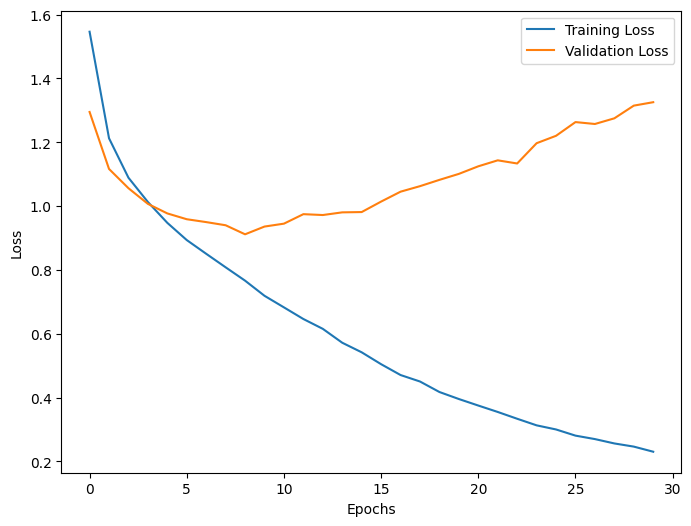

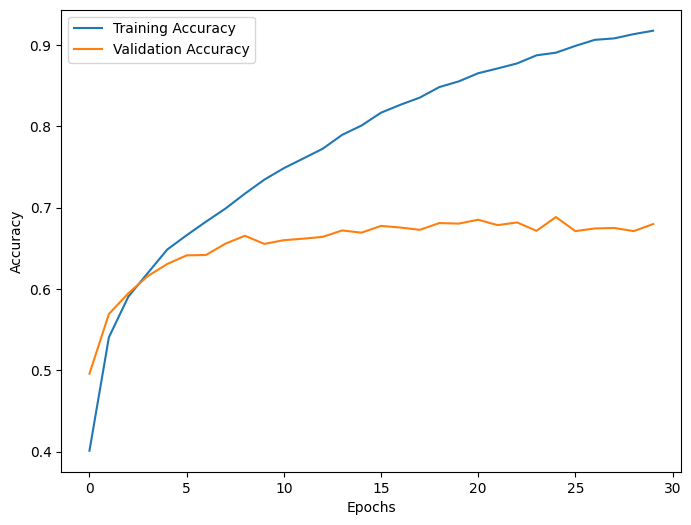

In [65]:
model = EfficientNet()
train(model, train_loader, valid_loader, config)

In [66]:
def draw_confusion_matrix(model, valid_loader):
    predictions, labels = [], []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img, lab in tqdm(valid_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
            labels += lab.tolist()
    # TODO draw the confusion matrix
    pass

draw_confusion_matrix(model, valid_loader)

100%|██████████| 46/46 [00:06<00:00,  7.48it/s]


### Testing

In [67]:
def test(model, test_loader):
    predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for img in tqdm(test_loader):
            img = img.to(device)
            output = model(img)
            predictions += torch.argmax(output, dim=-1).tolist()
    with open('predict.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for id, r in enumerate(predictions):
            writer.writerow([id, r])

In [68]:
model.load_state_dict(torch.load('model.pth'))
test(model, test_loader)

100%|██████████| 55/55 [00:03<00:00, 18.26it/s]
